<a href="https://colab.research.google.com/github/dm-fedorov/ml/blob/master/ai/04_%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D0%BE%D0%BC_k_%D1%81%D1%80%D0%B5%D0%B4%D0%BD%D0%B8%D1%85.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory" target="_blank"></a>

Самый простой из алгоритмов машинного обучения без учителя — `кластеризация методом k средних`. Алгоритм анализирует непомеченные образцы и пытается объединить их в кластеры.

Поясним, что `k` в «методе k средних» представляет количество кластеров, на которые предполагается разбить данные.

Алгоритм распределяет образцы на заранее заданное количество кластеров, используя метрики расстояния, сходные с метриками алгоритма кластеризации k ближайших соседей. Каждый кластер группируется вокруг `центроида` — центральной точки кластера. 

Изначально алгоритм выбирает k случайных центроидов среди образцов набора данных, после чего остальные образцы распределяются по кластерам с ближайшим центроидом. Далее выполняется итеративный пересчет центроидов, а образцы перераспределяются по кластерам, пока для всех кластеров расстояние от заданного центроида до образцов, входящих в его кластер, не будет минимизировано. 

В результате выполнения алгоритма формируется одномерный массив меток, обозначающих кластер, к которому относится каждый образец, а также двумерный массив центроидов, представляющих центр каждого кластера.

Рассмотрим пример с рекомендациями фильмов:

![alt text](https://raw.githubusercontent.com/dm-fedorov/ml/master/pic/kino.png)

### Набор данных Iris

Поработаем с популярным набором данных Iris, входящим в поставку scikit-learn. Этот набор часто анализируется при классификации и кластеризации. 

И хотя набор данных помечен, мы не будем использовать эти метки, чтобы продемонстрировать кластеризацию. Затем метки будут использованы для определения того, насколько хорошо `алгоритм k средних` выполняет кластеризацию образцов. 

Набор данных Iris относится к «игрушечным» наборам данных, поскольку состоит только из 150 образцов и четырех признаков. Набор данных описывает 50 образцов трех видов цветов ириса — Iris setosa, Iris versicolor и Iris virginica. 

Признаки образцов: длина наружной доли околоцветника (sepal length), ширина наружной доли околоцветника (sepal width), длина внутренней доли околоцветника (petal length) и ширина внутренней доли околоцветника (petal width), измеряемые в сантиметрах.

![alt text](https://raw.githubusercontent.com/dm-fedorov/ml/master/pic/iris.jpg)

Воспользуйтесь функцией `load_iris` модуля `sklearn.datasets` для получения объекта `Bunch` с набором данных:

In [1]:
from sklearn.datasets import load_iris

In [2]:
iris = load_iris()

Атрибут `DESCR` объекта Bunch показывает, что набор данных состоит из 150 образцов (Number of Instances), каждый из которых обладает четырьмя признаками (Number of Attributes). В наборе данных нет отсутствующих значений.

Образцы классифицируются целыми числами 0, 1 и 2, представляющими Iris setosa, Iris versicolor и Iris virginica соответственно. Проигнорируем метки и поручим определение классов образцов алгоритму кластеризации методом k
средних. 

In [3]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Количество образцов и признаков можно узнать из атрибута `shape` массива `data` , а количество целевых значений — из атрибута `shape` массива `target`:

In [4]:
iris.data.shape

(150, 4)

In [5]:
iris.target.shape

(150,)

Массив `target_names` содержит имена числовых меток массива. Выражение `dtype='<U10'` означает, что его элементами являются строки длиной не более 10 символов:

In [6]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Массив `feature_names` содержит список строковых имен для каждого столбца в массиве `data`:

In [7]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

Используем коллекцию DataFrame для исследования набора данных Iris. 

Зададим параметры pandas для форматирования столбцового вывода:

In [8]:
import pandas as pd
pd.set_option('max_columns', 5)
pd.set_option('display.width', None)

Создадим коллекцию DataFrame с содержимым массива `data`, используя содержимое массива `feature_names` как имена столбцов:

In [9]:
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)

Затем добавим столбец с названием вида для каждого из образцов. 

Трансформация списка в следующем фрагменте использует каждое значение в массиве `target` для поиска соответствующего названия в массиве `target_names`:

In [10]:
iris_df['species'] = [iris.target_names[i] for i in iris.target]

Воспользуемся pandas для идентификации нескольких образцов. 

In [11]:
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Вычислим некоторые показатели описательной статистики для числовых столбцов:

In [12]:
pd.set_option('precision', 2)

In [13]:
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.00,150.00,150.00,150.00
mean,5.84,3.06,3.76,1.20
std,0.83,0.44,1.77,0.76
min,4.30,2.00,1.00,0.10
25%,5.10,2.80,1.60,0.30
50%,5.80,3.00,4.35,1.30
75%,6.40,3.30,5.10,1.80
max,7.90,4.40,6.90,2.50


Вызов метода `describe` для столбца `'species'` подтверждает, что он содержит три уникальных значения. 

Нам заранее известно, что данные состоят из трех классов, к которым относятся образцы, хотя в машинном обучении без учителя это и не всегда так.

In [14]:
iris_df['species'].describe()

count        150
unique         3
top       setosa
freq          50
Name: species, dtype: object

### Визуализация набора данных функцией pairplot

Проведем визуализацию признаков в этом наборе данных. Один из способов извлечь информацию о ваших данных — посмотреть, как признаки связаны друг с другом. Набор данных имеет четыре признака. Мы не сможем построить диаграмму соответствия одного признака с тремя другими на одной диаграмме. Тем не менее можно построить диаграмму, на которой будет представлено соответствие между двумя признаками. 

Фрагмент далее использует функцию `pairplot` библиотеки Seaborn для создания таблицы диаграмм, на которых каждый признак сопоставляется с одним из других признаков:

In [15]:
import seaborn as sns

In [16]:
sns.set(font_scale=1.1)

In [17]:
sns.set_style('whitegrid')

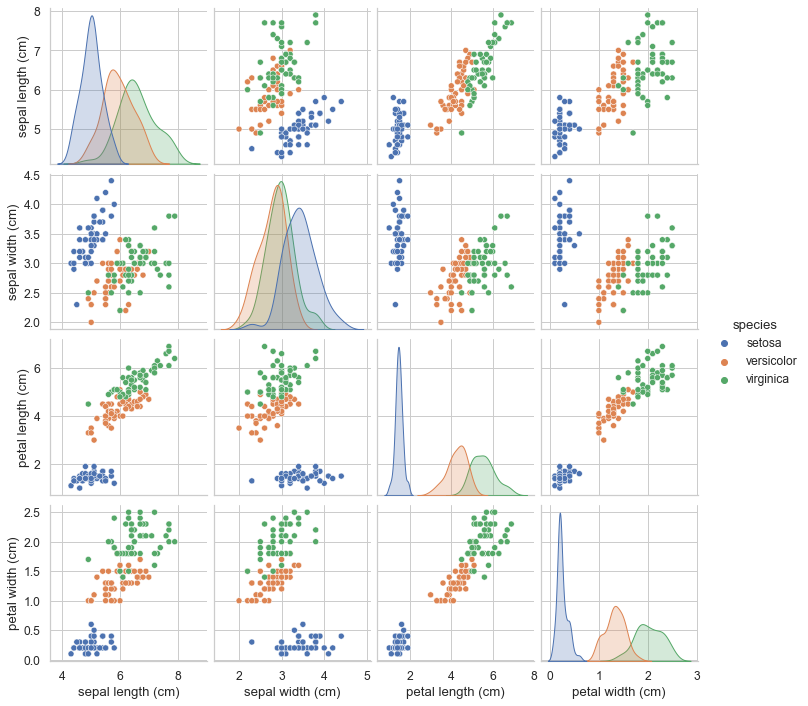

In [18]:
grid = sns.pairplot(data=iris_df, vars=iris_df.columns[0:4],
                    hue='species')

Ключевые аргументы:
* `data` — коллекция DataFrame с набором данных, наносимым на диаграмму;
* `vars` — последовательность с именами переменных, наносимых на диаграмму. Для коллекции DataFrame она содержит имена столбцов. В данном случае используются первые четыре столбца DataFrame , представляющие длину (ширину) наружной доли околоцветника и длину (ширину) внутренней доли околоцветника соответственно;
* `hue` — столбец коллекции DataFrame, используемый для определения цветов данных, наносимых на диаграмму. В данном случае данные окрашиваются в зависимости от вида ирисов.

Диаграммы на диагонали, ведущей из левого верхнего в правый нижний угол, показывают распределение признака, выведенного в этом столбце, с диапазоном значений (слева направо) и количеством образцов с этими значениями 
(сверху вниз). 

Самая высокая закрашенная область указывает, что диапазон значений длины наружной доли околоцветника (по оси x) для вида Iris setosa составляет приблизительно 4–6 см, а у большинства образцов Iris setosa значения лежат 
в середине этого диапазона (приблизительно 5 см). Крайняя правая закрашенная область указывает, что диапазон значений длины наружной доли околоцветника (по оси x) для вида Iris virginica составляет приблизительно 4–8,5 см, а у большинства образцов Iris virginica значения лежат между 6 и 7 см.

На других диаграммах в столбце представлены диаграммы разброса данных других признаков относительно признака по оси x. В первом столбце на первых трех диаграммах по оси y представлены ширина наружной доли околоцветника, длина внутренней доли околоцветника и ширина внутренней доли околоцветника соответственно, а на оси x — длина наружной доли околоцветника.

При выполнении этого кода на экране появляется цветное изображение, показывающее отношения между разными видами ирисов на уровне отдельных признаков. Интересно, что на всех диаграммах синие точки Iris setosa четко отделяются от оранжевых и зеленых точек других видов; это говорит о том, что Iris setosa действительно является отдельным классом. Также можно заметить, что других два вида иногда можно перепутать, на что указывают перекрывающиеся оранжевые и зеленые точки. Например, по диаграмме ширины и длины наружной доли околоцветника видно, что точки Iris versicolor и Iris virginica смешиваются. Это говорит о том, что если доступны только измерения наружной доли околоцветника, то различить эти два вида будет сложно.

Если убрать ключевой аргумент `hue`, то функция `pairplot` использует только один цвет для вывода всех данных, потому что она не знает, как различать виды при выводе:

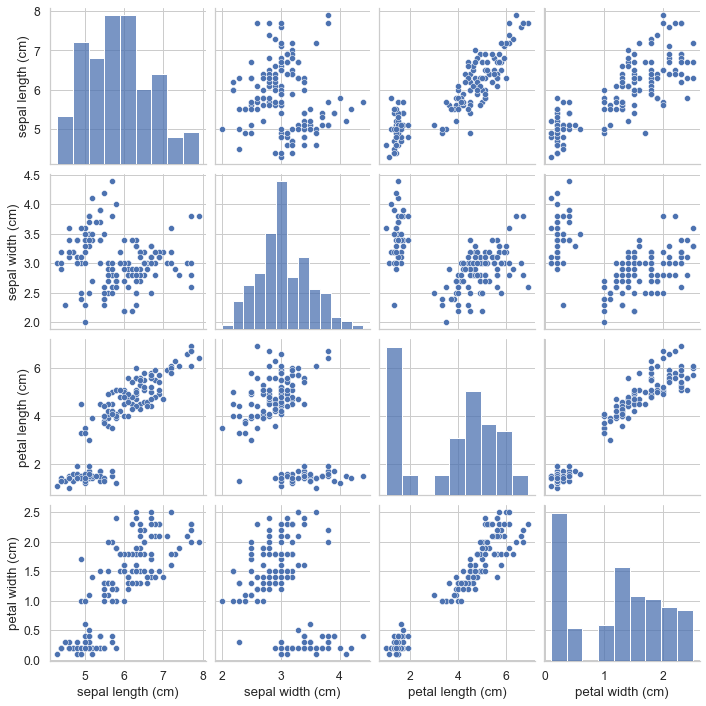

In [19]:
grid = sns.pairplot(data=iris_df, vars=iris_df.columns[0:4])

Как видно из следующей диаграммы, в данном случае диаграммы на диагонали представляют собой гистограммы с распределениями всех значений этого признака независимо от вида. При изучении диаграмм может показаться, что существуют всего два кластера, хотя мы знаем, что в наборе содержатся данные трех видов. Если количество кластеров неизвестно заранее, то можно обратиться к эксперту предметной области, хорошо знакомому с данными.
Эксперт может знать, что в наборе данных присутствуют три вида; эта информация может пригодиться при проведении машинного обучения с данными.

Диаграммы pairplot хорошо работают при малом количестве признаков или подмножестве признаков, чтобы количество строк и столбцов было ограниченным, и при относительно небольшом количестве образцов, чтобы были видны точки данных. С ростом количества признаков и образцов диаграммы разброса данных становятся слишком мелкими для чтения данных. В больших наборах данных можно нанести на диаграмму подмножество признаков и, возможно, случайно выбранное подмножество образцов, чтобы получить некоторое представление о данных.

### Использование оценщика KMeans

В этом разделе будет применена кластеризация методом k средних с оценщиком `KMeans` библиотеки scikit-learn (из модуля sklearn.cluster) для распределения образцов набора данных Iris по кластерам. 

Как и с другими оценщиками, которыми мы пользовались ранее, оценщик `KMeans` скрывает от вас сложные математические подробности реализации алгоритма, чтобы им было удобно пользоваться.

Создадим объект KMeans:

In [20]:
from sklearn.cluster import KMeans

In [21]:
kmeans = KMeans(n_clusters=3, random_state=11)

Ключевой аргумент `n_clusters` определяет гиперпараметр `k` алгоритма кластеризации методом k средних, необходимый `KMeans` для вычисления кластеров и пометки образцов. 

В процессе обучения оценщика `KMeans` алгоритм вычисляет для каждого кластера центроид, представляющий центральную точку данных этого кластера.

По умолчанию значение параметра `n_clusters` равно 8. 

Нередко для выбора подходящего значения `k` приходится полагаться на знания экспертов предметной области. Тем не менее настройка гиперпараметра позволяет получить оценку оптимального значения `k`, как это будет сделано позднее. В данном случае мы знаем, что набор содержит данные трех видов, поэтому для проверки эффективности `KMeans` при пометке образцов ирисов используется значение `n_clusters=3`. И снова ключевое слово `random_state` используется для обеспечения воспроизводимости результатов.

### Подгонка модели

Затем происходит обучение оценщика, для чего вызывается метод `fit` объекта `KMeans` и выполняется алгоритм k средних, рассмотренный ранее:

In [22]:
kmeans.fit(iris.data)

KMeans(n_clusters=3, random_state=11)

Как и у других оценщиков, метод `fit` возвращает объект оценщика. 

Список аргументов по умолчанию для `KMeans` можно просмотреть по [адресу](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

Когда обучение завершено, объект `KMeans` содержит:
* Массив `labels_` со значениями от 0 до `n_clusters-1` (в данном случае `0–2`), обозначающими кластеры, к которым принадлежат образцы.
* Массив `cluster_centers_` , каждая строка которого представляет центроид.

### Сравнение меток кластеров с целевыми значениями из набора данных

Так как набор Iris размечен, мы можем проверить значения из его массива `target`, чтобы составить представление о том, насколько эффективно алгоритм k средних выполняет кластеризацию для трех видов ирисов. 

С непомеченными данными вам придется обратиться к эксперту предметной области, который поможет оценить разумность прогнозируемых классов.

В этом наборе данных первые 50 образцов относятся к виду Iris setosa, следующие 50 — к виду Iris versicolor, а последние 50 — к виду Iris virginica. Массив target набора данных Iris представляет образцы со значениями 0–2. 

Если оценщик KMeans выбрал кластеры идеально, то все группы из 50 элементов массива `labels_` оценщика будут обладать разными метками. При изучении приведенных ниже результатов следует заметить, что оценщик KMeans использует значения от 0 до k–1 для пометки кластеров, но эти значения не связаны со значениями из массива `target` набора данных Iris.

Сегментация поможет оценить результаты кластеризации для каждой группы из 50 образцов ирисов. Следующий фрагмент показывает, что первые 50 образцов были объединены в кластер 1:

In [23]:
print(kmeans.labels_[0:50])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


Следующие 50 образцов должны быть помещены во второй кластер. Фрагмент показывает, что большинство из них попало в кластер 0, но два образца были отнесены к кластеру 2:

In [24]:
print(kmeans.labels_[50:100])

[0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


Аналогичным образом последние 50 образцов должны быть помещены в третий кластер. Следующий фрагмент показывает, что многие из этих образцов попали в кластер 2, но 14 из них были помещены в кластер 0; алгоритм решил, 
что они принадлежат к другому кластеру:

In [25]:
print(kmeans.labels_[100:150])

[2 0 2 2 2 2 0 2 2 2 2 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 0 2 2 2
 2 0 2 2 2 0 2 2 2 0 2 2 0]


Результаты этих трех фрагментов подтверждают то, что мы уже видели на диаграммах pairplot ранее в этом разделе, — Iris setosa выделяется в обособленный класс, а Iris versicolor можно спутать с Iris virginica.

### Понижение размерности методом анализа главных компонент

Затем воспользуемся оценщиком `PCA` (из модуля `sklearn.decomposition`) для выполнения понижения размерности. 

Этот оценщик использует алгоритм, называемый [анализом главных компонент](https://scikit-learn.org/stable/modules/decomposition.html#pca), для анализа признаков набора данных и их сведения к заданному количеству измерений. 

### Создание объекта PCA

Оценщик `PCA` использует ключевой аргумент `n_components` для определения количества измерений:

In [26]:
from sklearn.decomposition import PCA

In [27]:
pca = PCA(n_components=2, random_state=11)

### Преобразование признаков набора данных Iris к двум измерениям

Обучим оценщика и получим данные сокращенной размерности вызовом методов `fit` и `transform` оценщика PCA :

In [28]:
pca.fit(iris.data)

PCA(n_components=2, random_state=11)

In [29]:
iris_pca = pca.transform(iris.data)

Когда метод завершит свою задачу, он возвращает массив с таким же количеством строк, как у `iris.data`, но только с двумя столбцами. Чтобы убедиться в этом, проверим атрибут `shape` объекта `iris_pca`:

In [30]:
iris_pca.shape

(150, 2)

Обратите внимание: на этот раз мы вызываем методы `fit` и `transform` оценщика `PCA` вместо метода `fit_transform`. 

В этом примере мы повторно используем обученного оценщика (полученного вызовом `fit`) для выполнения второго преобразования с целью сокращения центроидов кластеров от четырех измерений до двух. Это позволит нам нанести на диаграмму местоположения центроидов для каждого кластера.

### Визуализация данных с пониженной размерностью

Теперь, когда исходный набор данных был сокращен до двух измерений, воспользуемся диаграммой разброса данных для вывода. Для этого применим функцию `scatterplot` библиотеки Seaborn. Начнем с преобразования данных с пониженной размерностью в DataFrame и добавления столбца `species`, который будет использоваться для определения цветов точек:

In [31]:
iris_pca_df = pd.DataFrame(iris_pca,
                           columns=['Component1', 'Component2'])

In [32]:
iris_pca_df['species'] = iris_df.species

Данные выводятся на диаграмме вызовом `scatterplot`:

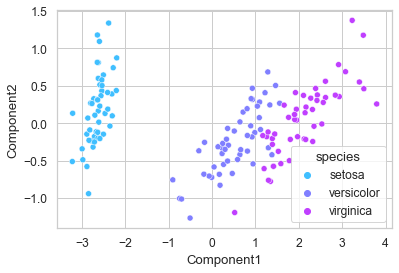

In [33]:
axes = sns.scatterplot(data=iris_pca_df, x='Component1',
                       y='Component2', hue='species', legend='brief',
                       palette='cool')

Каждый центроид из массива `cluster_centers_` объекта KMeans имеет такое же количество признаков, как и исходный набор данных (4 — в данном случае). 

Чтобы нанести на диаграмму центроиды, необходимо понизить их размерность. 

Центроид можно рассматривать как «усредненный» образец в кластере. Таким образом, каждый центроид должен быть преобразован тем же оценщиком PCA , который использовался для понижения размерности других образцов в этом кластере:

In [34]:
iris_centers = pca.transform(kmeans.cluster_centers_)

Теперь нанесем центроиды трех кластеров в виде черных точек большего размера. Вместо того чтобы преобразовывать массив iris_centers в DataFrame, используем функцию scatter библиотеки Matplotlib для нанесения на диаграмму трех центроидов:

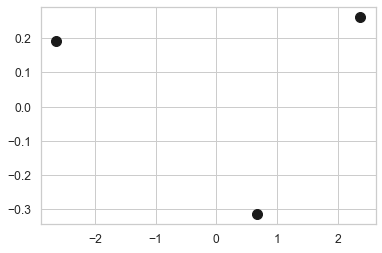

In [35]:
import matplotlib.pyplot as plt
dots = plt.scatter(iris_centers[:,0], iris_centers[:,1],
                   s=100, c='k')

Ключевой аргумент s=100 задает размер точек на диаграмме, а ключевой аргумент c='k' указывает, что точки должны выводиться черным цветом.

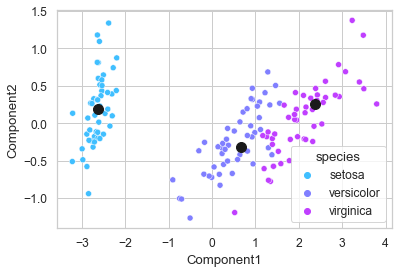

In [36]:
axes = sns.scatterplot(data=iris_pca_df, x='Component1',
                       y='Component2', hue='species', legend='brief',
                       palette='cool')
iris_centers = pca.transform(kmeans.cluster_centers_)
import matplotlib.pyplot as plt
dots = plt.scatter(iris_centers[:,0], iris_centers[:,1],
                   s=100, c='k')

### Выбор оптимального оценщика для кластеризации

Как и в примерах классификации и регрессии, выполним несколько алгоритмов кластеризации и посмотрим, как они справляются с кластеризацией цветов ириса. 

Попытаемся провести кластеризацию образцов набора данных Iris с объектом `kmeans`, который был создан ранее, а также с объектами scikit-learn `DBSCAN`, `MeanShift`, `SpectralClustering` и `AgglomerativeClustering`. Как и в случае с `KMeans`, количество кластеров для оценщиков `SpectralClustering` и `AgglomerativeClustering` задается заранее:

In [37]:
from sklearn.cluster import DBSCAN, MeanShift,\
                            SpectralClustering, AgglomerativeClustering

In [38]:
estimators = {
    'KMeans': kmeans,
    'DBSCAN': DBSCAN(),
    'MeanShift': MeanShift(),
    'SpectralClustering': SpectralClustering(n_clusters=3),
    'AgglomerativeClustering':
                            AgglomerativeClustering(n_clusters=3)
}

Каждая итерация следующего цикла вызывает метод `fit` одного оценщика с аргументом `iris.data`, после чего использует функцию `unique` библиотеки NumPy для получения меток и численности кластеров для трех групп по
50 образцов, после чего выводит результаты. 

Вспомните, что для оценщиков `DBSCAN` и `MeanShift` количество кластеров не указывалось заранее. Интересно, что DBSCAN правильно прогнозирует наличие трех кластеров (с метками –1, 0 и 1), хотя и помещает 84 из 100 образцов Iris virginica и Iris versicolor в один кластер. 

С другой стороны, оценщик `MeanShift` прогнозирует всего два кластера (с метками 0 и 1) и помещает 99 из 100 образцов Iris virginica и Iris versicolor в один кластер:

In [39]:
import numpy as np
for name, estimator in estimators.items():
    estimator.fit(iris.data)
    print(f'\n{name}:')
    for i in range(0, 101, 50):
        labels, counts = np.unique(
            estimator.labels_[i:i+50], return_counts=True)
        print(f'{i}-{i+50}:')
        for label, count in zip(labels, counts):
            print(f'label={label}, count={count}')


KMeans:
0-50:
label=1, count=50
50-100:
label=0, count=48
label=2, count=2
100-150:
label=0, count=14
label=2, count=36

DBSCAN:
0-50:
label=-1, count=1
label=0, count=49
50-100:
label=-1, count=6
label=1, count=44
100-150:
label=-1, count=10
label=1, count=40

MeanShift:
0-50:
label=1, count=50
50-100:
label=0, count=49
label=1, count=1
100-150:
label=0, count=50

SpectralClustering:
0-50:
label=1, count=50
50-100:
label=2, count=50
100-150:
label=0, count=35
label=2, count=15

AgglomerativeClustering:
0-50:
label=1, count=50
50-100:
label=0, count=49
label=2, count=1
100-150:
label=0, count=15
label=2, count=35


Хотя эти алгоритмы помечают каждый образец, метки всего лишь отражают принадлежность к определенному кластеру. Что делать с информацией о кластерах, когда она у вас появится? Если вы стремитесь к тому, чтобы использовать данные в машинном обучении с учителем, то обычно анализируете образцы в каждом кластере, пытаетесь определить, как они связаны друг с другом, и помечаете их соответствующим образом. 